In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow.compat.v2 as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_datasets as tfds
from tensorflow.python.keras.utils import np_utils
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rn2021q1itba-cifar100/submission_example.csv
/kaggle/input/rn2021q1itba-cifar100/y_train.npy
/kaggle/input/rn2021q1itba-cifar100/x_test.npy
/kaggle/input/rn2021q1itba-cifar100/x_train.npy


In [31]:
x_train = np.load("/kaggle/input/rn2021q1itba-cifar100/x_train.npy")
x_test = np.load("/kaggle/input/rn2021q1itba-cifar100/x_test.npy")
y_train = np.load("/kaggle/input/rn2021q1itba-cifar100/y_train.npy")


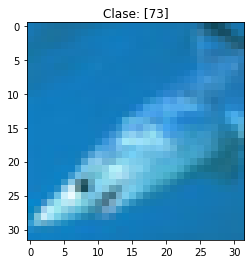

In [32]:
from matplotlib import pyplot as plt
#Mostramos alguna imágen
idx = 50
plt.imshow(x_train_val[idx])
plt.title(f'Clase: {y_train_val[idx]}')
plt.show()

In [33]:
#Dividimos entre train y validación
from sklearn.model_selection import train_test_split


# x_train, x_val, y_train, y_val = train_test_split(
#     x_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

# print(np.array(y_train).shape)
# print(np.array(x_train).shape)


# x_train = tf.convert_to_tensor(x_train, dtype=tf.int32)
# x_val = tf.convert_to_tensor(x_val, dtype=tf.int32)
# y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
# y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

In [34]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_val, y_val = x_train[40000:50000,:], y_train[40000:50000]
x_train, y_train = x_train[:50000,:], y_train[:50000]

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)


y_train = np_utils.to_categorical(y_train, 100)
y_val = np_utils.to_categorical(y_val, 100)

In [35]:
#Armamos la red de clasificación
from tensorflow.keras.layers import Dense, Flatten, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator  

In [36]:
data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [37]:
model = Sequential()

model.add(Conv2D(128,3, input_shape=(32,32,3)))
model.add(Conv2D(128,3))
model.add(Conv2D(128,1))
# model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(128,3))
model.add(Conv2D(128,3))
model.add(Conv2D(128,1))
# model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))

model.add(Conv2D(256,3))
model.add(Conv2D(256,1))
# model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dense(100, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer= Adam(learning_rate=0.001), metrics=["accuracy"])

In [38]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(x_train)

it_train = datagen.flow(x_train, y_train, batch_size = 64)

steps = int(x_train.shape[0] / 64)
model.fit(it_train,
         validation_data=(x_val, y_val),
         steps_per_epoch=steps, epochs=50)

#model.fit(x_train_norm, y_train, validation_data = (x_val, y_val), epochs=50, callbacks=[early_stop])
model.summary()

Epoch 1/50
781/781 [==============================] - 37s 46ms/step - loss: 4.2364 - accuracy: 0.0554 - val_loss: 3.4770 - val_accuracy: 0.1648
Epoch 2/50
781/781 [==============================] - 36s 46ms/step - loss: 3.4486 - accuracy: 0.1726 - val_loss: 3.0895 - val_accuracy: 0.2383
Epoch 3/50
781/781 [==============================] - 36s 45ms/step - loss: 3.1327 - accuracy: 0.2324 - val_loss: 2.8553 - val_accuracy: 0.2862
Epoch 4/50
781/781 [==============================] - 35s 45ms/step - loss: 2.9492 - accuracy: 0.2672 - val_loss: 2.8160 - val_accuracy: 0.3021
Epoch 5/50
781/781 [==============================] - 36s 46ms/step - loss: 2.8553 - accuracy: 0.2848 - val_loss: 2.6416 - val_accuracy: 0.3366
Epoch 6/50
781/781 [==============================] - 35s 45ms/step - loss: 2.7746 - accuracy: 0.3017 - val_loss: 2.4443 - val_accuracy: 0.3710
Epoch 7/50
781/781 [==============================] - 35s 45ms/step - loss: 2.6931 - accuracy: 0.3193 - val_loss: 2.5089 - val_accuracy: